# **Modelagem preços de ações com Redes Neurais Recorrentes - LSTM**

Nesse pequeno projeto iremos aplicar uma rede neural artificial para modelar e gerar previsões com séries temporais. A rede neural que usaremos se chama *LSTM* (ou *Long short-term memory*) e é uma rede neural recorrente, ou seja, ela é uma estrutura de processamento que consegue representar grandes variedades de comportamentos dinâmicos. 

As redes neurais recorrentes possuem mecanismos de *loops*, permitindo que haja realimentação de informação e a criação de representações internas e mecanismos de **memória** que permitem armazenar infomações temporais (principalmente de séries temporais). O fato de possuir muitos *loops*, mesmo com um número reduzido de parâmetros, a rede neural pode gerar um comportamento complexo.




## Dados

Os dados foram extraídos da plataforma *Yahoo* e são os preços das ações da Petróleo Brasileiro S/A (Petrobras) na Bolsa de valores americana. A peoridicidade é diária e vai do dia 1 de janeiro de 2014 até 31 de março de 2020. Aqui, iremos modelar os preços de fechamento das ações *PBR*.




## Importação das bibliotecas

In [110]:
pip install yfinance

In [111]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from pandas_datareader import data as pdr
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
import plotly.graph_objects as go
plt.style.use('fivethirtyeight')

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

## Importa dos dados

Vamos usar o *DataReader* para extrair os dados da platadforma *Yahoo* com a periodicidade e intervalo que queremos.

In [112]:
#df=web.DataReader('PBR', 'yahoo',start='2014-01-01',end='2020-03-31')
yf.pdr_override()
df = pdr.get_data_yahoo("PBR", start="2014-01-01", end="2020-12-30")

[*********************100%***********************]  1 of 1 completed


## Análise Exploratória dos dados

Podemos ver as 5 primeiras observações dos 5 preços que foram extraídos (de alta, de baixa, de abertura, de fechamento e o de fechamento ajustado) e o volume de ações que foram negociadas no dia.

In [113]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,13.45,13.50,13.20,13.32,11.423830,18218000
2014-01-03,13.26,13.37,13.00,13.12,11.252300,19993700
2014-01-06,12.97,13.20,12.89,13.16,11.286609,12475200
2014-01-07,13.38,13.38,12.82,12.90,11.063619,19305300
2014-01-08,12.93,12.96,12.66,12.68,10.874936,17711000


Temos 1572 observações no nosso conjunto de dados.

In [114]:
df.shape

(1761, 6)

A colunas não possuem nenhum valor faltante.

In [115]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Todos os dados são do tipo *float*.

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2014-01-02 to 2020-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1761 non-null   float64
 1   High       1761 non-null   float64
 2   Low        1761 non-null   float64
 3   Close      1761 non-null   float64
 4   Adj Close  1761 non-null   float64
 5   Volume     1761 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 96.3 KB


Abaixo podemos ver a tabela estatística de todas as variáveis.

In [117]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1.761000e+03
mean,10.643044,10.825145,10.449512,10.634696,9.470479,2.573621e+07
std,3.702759,3.728991,3.668783,3.699671,3.305276,1.520167e+07
min,2.880000,2.970000,2.710000,2.900000,2.570413,2.875700e+06
25%,7.990000,8.230000,7.810000,8.010000,7.126250,1.585200e+07
50%,10.270000,10.430000,10.120000,10.250000,9.085082,2.235310e+07
75%,14.120000,14.310000,13.920000,14.110000,12.595078,3.068980e+07
max,20.830000,20.940001,19.959999,20.650000,18.303114,1.810443e+08


Visualizando as séries de preços e volume de ações.

In [118]:
df.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.998997,0.998770,0.997761,0.997198,-0.248756
High,0.998997,1.000000,0.998639,0.998990,0.998336,-0.233662
Low,0.998770,0.998639,1.000000,0.999090,0.998625,-0.266943
Close,0.997761,0.998990,0.999090,1.000000,0.999439,-0.251050
Adj Close,0.997198,0.998336,0.998625,0.999439,1.000000,-0.253620
Volume,-0.248756,-0.233662,-0.266943,-0.251050,-0.253620,1.000000


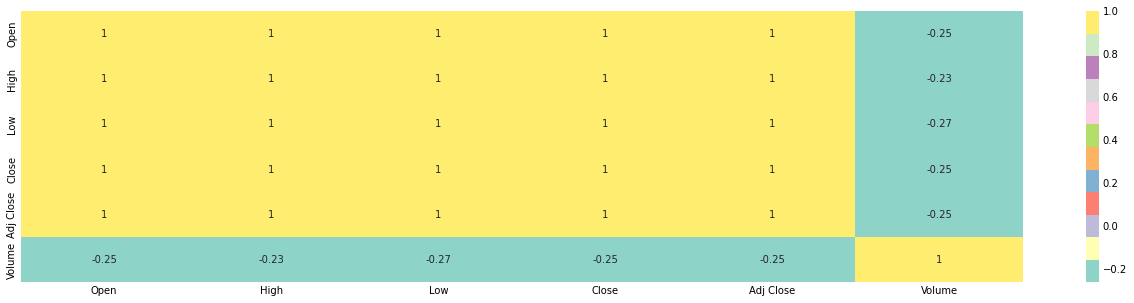

In [119]:
%matplotlib inline
plt.figure(figsize=(20,5))
correlacao=df.corr()
sns.heatmap(correlacao, annot = True, cmap = "Set3");

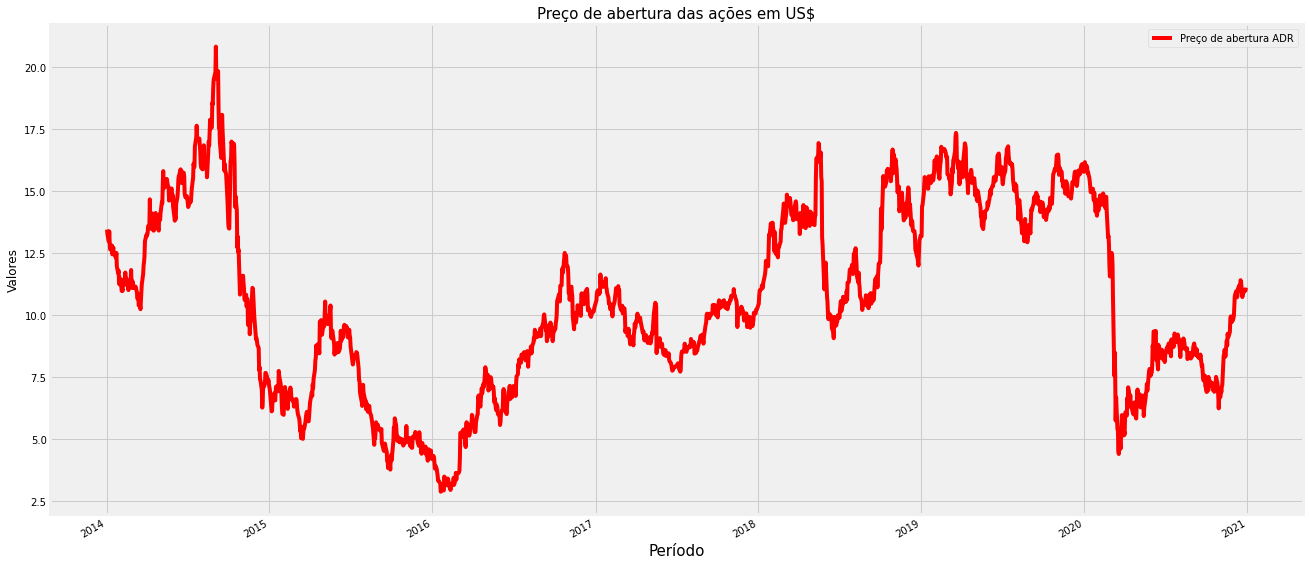

In [120]:
plt.figure(figsize=(20,10))
df['Open'].plot(color='red')
plt.title('Preço de abertura das ações em US$', size=15)
plt.xlabel('Período',size=15)
plt.ylabel('Valores')
plt.legend(['Preço de abertura ADR'])
plt.show()

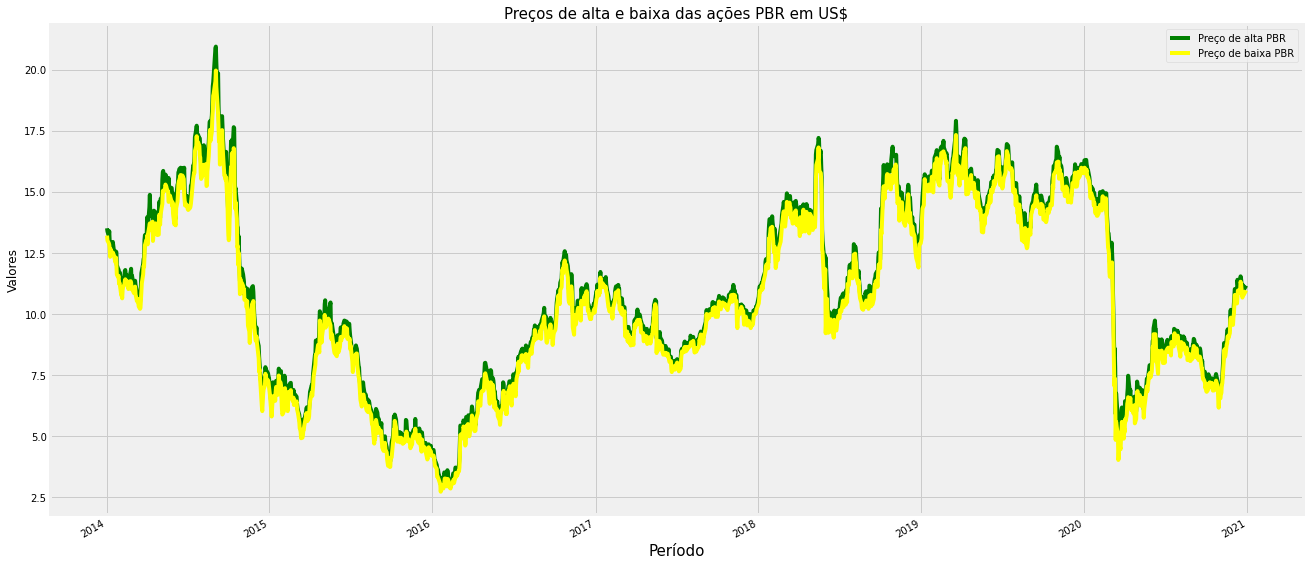

In [121]:
plt.figure(figsize=(20,10))
df['High'].plot(color='green')
df['Low'].plot(color='yellow')
plt.title('Preços de alta e baixa das ações PBR em US$', size=15)
plt.xlabel('Período',size=15)
plt.ylabel('Valores')
plt.legend(['Preço de alta PBR','Preço de baixa PBR'])
plt.show()

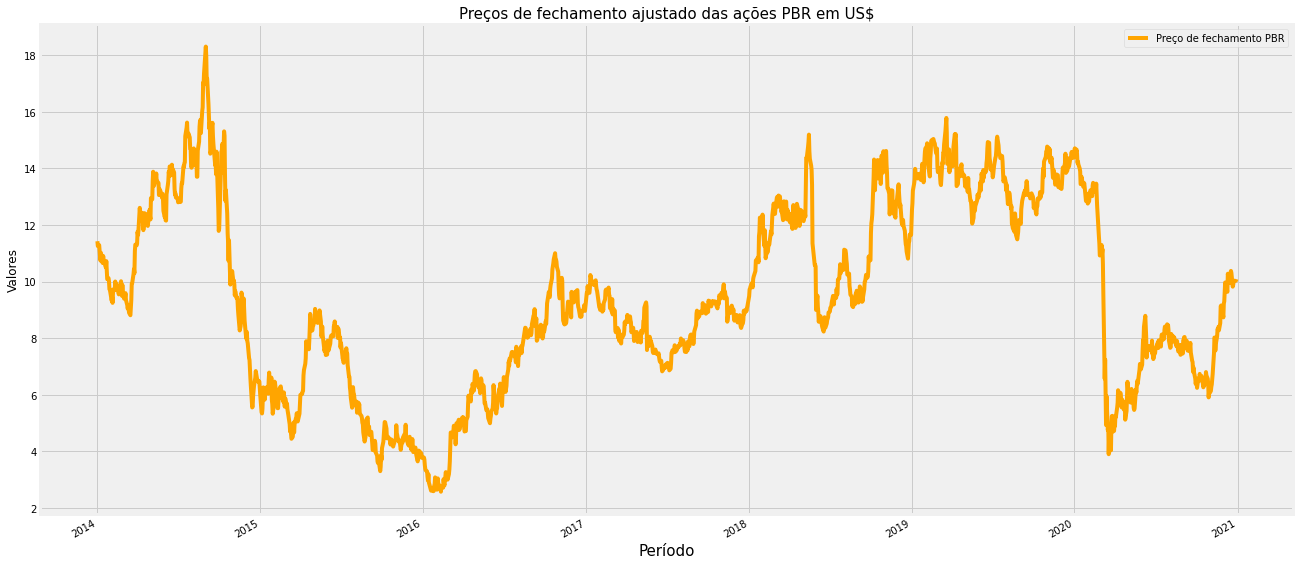

In [122]:
plt.figure(figsize=(20,10))
df['Adj Close'].plot(color='orange')
plt.title('Preços de fechamento ajustado das ações PBR em US$', size=15)
plt.xlabel('Período',size=15)
plt.ylabel('Valores')
plt.legend(['Preço de fechamento PBR'])
plt.show()

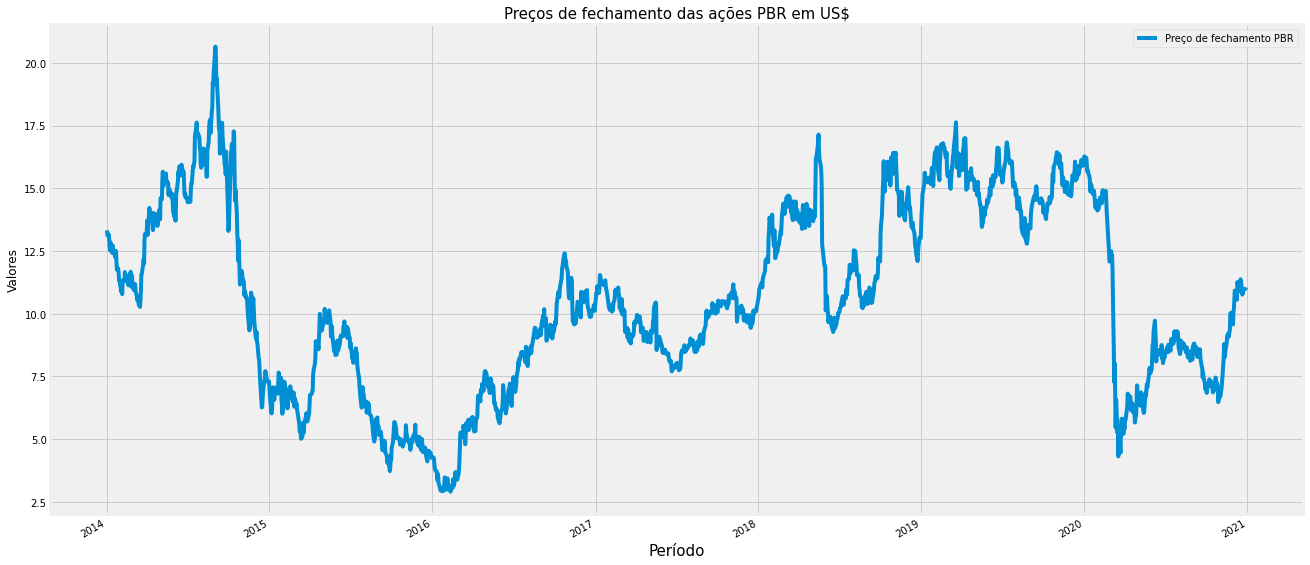

In [123]:
plt.figure(figsize=(20,10))
df['Close'].plot()
plt.title('Preços de fechamento das ações PBR em US$', size=15)
plt.xlabel('Período',size=15)
plt.ylabel('Valores')
plt.legend(['Preço de fechamento PBR'])
plt.show()

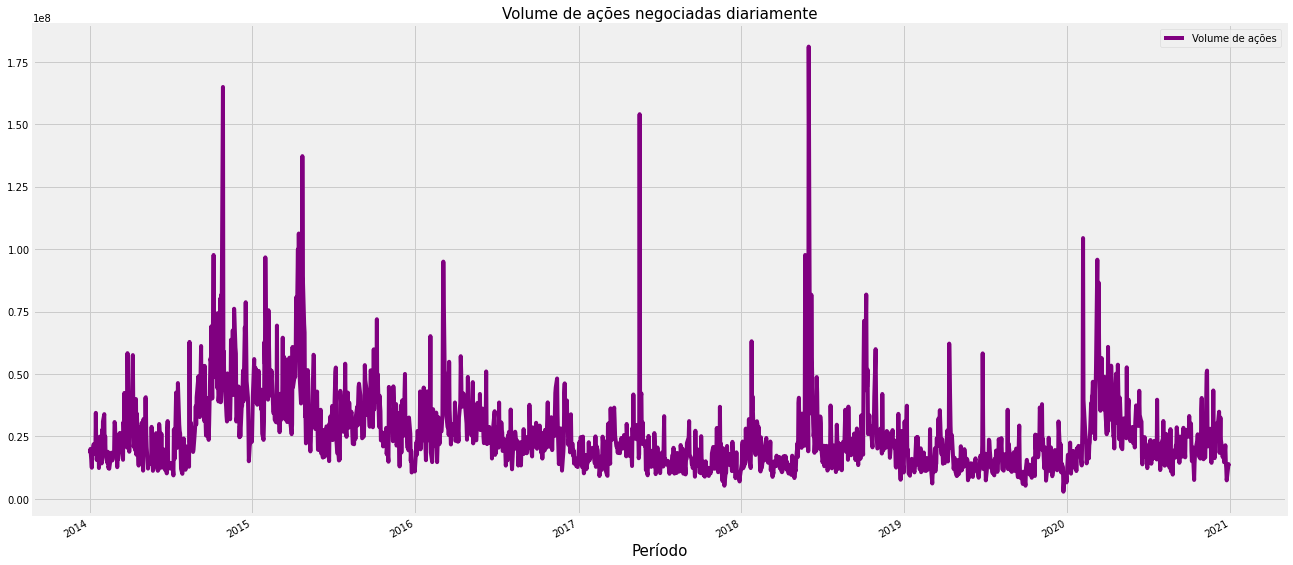

In [124]:
plt.figure(figsize=(20,10))
df['Volume'].plot(color='purple')
plt.title('Volume de ações negociadas diariamente', size=15)
plt.xlabel('Período',size=15)
plt.ylabel('')
plt.legend(['Volume de ações'])
plt.show()

## Dados de treino e de teste

Vamos agora separar os dados de treino. Vamos escolher para os dados de treino 80% da série temporal. Para o treino teremos 1258 observações.

In [125]:
#Da série vamos extrair apenas os dados de fechamento
data=df.filter(['Close'])
#selecionar seus valores
dataset=data.values
#separa 80% desses dados
training_data_len=math.ceil(len(dataset)*.8)
#e vamos visualizar quantas observações temos
training_data_len

1409

### Alterando a escala dos dados

In [126]:
#escalando para o intervalo entre 0 e 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.58704225],
       [0.57577465],
       [0.57802817],
       ...,
       [0.45464791],
       [0.45577464],
       [0.45915495]])

### Separando as bases de treino e teste

In [127]:
#criando um dataset de treino
train_data = scaled_data[0:training_data_len,:]
#separando dados de treino e teste
x_train=[]
y_train=[]

for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if i<=61:
    print(x_train)
    print(y_train)
    print()

[array([0.58704225, 0.57577465, 0.57802817, 0.56338027, 0.55098594,
       0.54197187, 0.56000002, 0.53859156, 0.53633804, 0.55267607,
       0.5430986 , 0.53971829, 0.52619718, 0.54084508, 0.52169014,
       0.49915495, 0.50140847, 0.49352113, 0.47549297, 0.47549297,
       0.46816902, 0.44901408, 0.45802816, 0.44394365, 0.46873242,
       0.47549297, 0.47323945, 0.49352113, 0.48225353, 0.48788736,
       0.48507044, 0.46760563, 0.46366199, 0.47211267, 0.48056341,
       0.49408452, 0.47492958, 0.46028168, 0.48563384, 0.46760563,
       0.45352112, 0.46140847, 0.45746482, 0.4664789 , 0.45070421,
       0.43830988, 0.43042254, 0.43887322, 0.43042254, 0.42084507,
       0.4152113 , 0.43154933, 0.45070421, 0.48845069, 0.48957748,
       0.51098594, 0.52225353, 0.51267606, 0.56450706, 0.57915496])]
[0.5774647773813806]

[array([0.58704225, 0.57577465, 0.57802817, 0.56338027, 0.55098594,
       0.54197187, 0.56000002, 0.53859156, 0.53633804, 0.55267607,
       0.5430986 , 0.53971829, 0.526

###convertendo *x_train* e *y_train* para um *array numpy*

In [128]:
x_train,y_train = np.array(x_train), np.array(y_train)
#dimensões dos arrays
print(x_train.shape)
print(y_train.shape)

### Redimensionamento dos dados

In [131]:
x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_train.shape

(1349, 60, 1)

### Criando a base de teste

Vamos separar um conjunto de dados que serão os dados de validação.

In [63]:
#criando os dados de teste
test_data=scaled_data[training_data_len-60:,:]

#criando x_test e y_test
x_test=[]
y_test=dataset[training_data_len:,:]

for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])

x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

## Criando o modelo

Nesse modelo eu irei inserir 3 camadas

In [152]:
model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

Compilando o modelo.

In [178]:
model.compile(optimizer='adam', loss='mse')

## Treinando o modelo

Para o nosso modelo irei 10 épocas, mas é possível inserir mais épocas para melhorar o treinamento do modelo.

In [179]:
model.fit(x_train, y_train, batch_size=100,epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
14/14 [==============================] - 9s 263ms/step - loss: 0.0072 - val_loss: 116.5519
Epoch 2/10
14/14 [==============================] - 2s 161ms/step - loss: 0.0032 - val_loss: 116.7352
Epoch 3/10
14/14 [==============================] - 2s 158ms/step - loss: 0.0024 - val_loss: 117.3074
Epoch 4/10
14/14 [==============================] - 2s 153ms/step - loss: 0.0021 - val_loss: 117.6312
Epoch 5/10
14/14 [==============================] - 2s 161ms/step - loss: 0.0020 - val_loss: 117.5444
Epoch 6/10
14/14 [==============================] - 2s 164ms/step - loss: 0.0019 - val_loss: 117.2803
Epoch 7/10
14/14 [==============================] - 2s 167ms/step - loss: 0.0020 - val_loss: 117.4438
Epoch 8/10
14/14 [==============================] - 2s 163ms/step - loss: 0.0017 - val_loss: 117.5737
Epoch 9/10
14/14 [==============================] - 2s 162ms/step - loss: 0.0017 - val_loss: 117.4822
Epoch 10/10
14/14 [==============================] - 2s 167ms/step - loss: 0.0015 

### Sumário do modelo

In [169]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 60, 50)            10400     
                                                                 
 lstm_11 (LSTM)              (None, 60, 50)            20200     
                                                                 
 lstm_12 (LSTM)              (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 52,101
Trainable params: 52,101
Non-trainable params: 0
_________________________________________________________________


## Gerando as previsões

In [170]:
predictions = model.predict(x_test)
#invertendo a escala
predictions = scaler.inverse_transform(predictions)

### Métricas de avaliação

Vamos agora utilizar as métricas de avaliaçãó para ver o desempenho do modelo, comparando os dados de teste e as previsões geradas. Geralmente eu prefiro usar a métrica *R²*, pois ela vai revela o quanto as previsões estão alinhadas com os valores reais (quanto mais próximo de 1, melhor), as outras medidas são mais usadas para comparar com o desempenho de outros modelos.

In [171]:
print('Erro médio absoluto :', mean_absolute_error(predictions,y_test))
print('Erro médio quadrado logarítmico :', mean_squared_log_error(predictions,y_test))
print('Erro medio quadrado :', mean_squared_error(predictions,y_test))
print('Coeficiente de determinação (R²):', r2_score(predictions,y_test))

Erro médio absoluto : 0.6336373740976508
Erro médio quadrado logarítmico : 0.010518185304883717
Erro medio quadrado : 0.9197712052787508
Coeficiente de determinação (R²): 0.9244917199029871


### Gráfico Previsões *vs* Valores reais.

In [172]:
#plotando os dados
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Predictions'] = predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



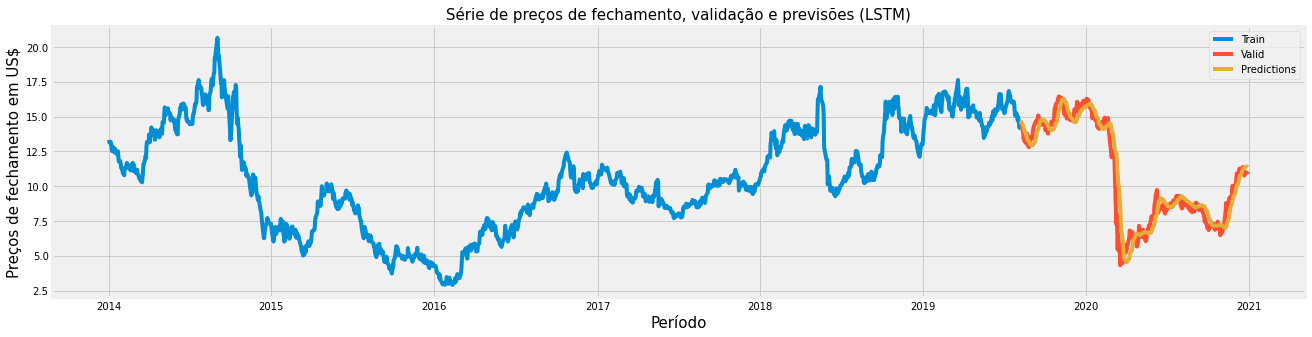

In [173]:
plt.figure(figsize=(20,5))
plt.title('Série de preços de fechamento, validação e previsões (LSTM)',size=15)
plt.xlabel('Período',size=15)
plt.ylabel('Preços de fechamento em US$',size=15)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Valid','Predictions'])
plt.show()

## Gerando previsões com o modelo

O modelo *LSTM* á bom para realizar a previsão de um passo a frente, entretanto é possível realizar a previsão para um horizonte maior de tempo. Aqui irei gerar previsões para 60 dias a frente e depois irei visualizar graficamente o resultado.

In [174]:
#selecionando todos os dados de fechamento e redimensionando-os
dados_fechamento = df['Close'].values.reshape((-1))
 
#criando uma função para gerar as previsões
def predict(numero_previsoes, modelo):
    lista_prev = dados_fechamento[-60:]
     
    for _ in range(numero_previsoes):
        x = lista_prev[-60:]
        x = x.reshape((1, 60, 1))
        out = model.predict(x)[0][0]
        lista_prev = np.append(lista_prev, out)
    lista_prev = lista_prev[60-1:]
         
    return lista_prev

#Criando uma função para as datas das previsões     
def predict_dates(numero_previsoes):
    ultima_data = df.index.values[-1]
    data_prev = pd.date_range(ultima_data, periods=numero_previsoes+1).tolist()
    return data_prev

#número de períodos
numero_previsoes = 60
previsoes = predict(numero_previsoes, model)
forecast_dates = predict_dates(numero_previsoes)

## Plotando a série e suas previsões.

Obtendo os valores reais das previsões dos próximos 60 dias.

In [175]:
df2 = pdr.get_data_yahoo("PBR", start="2020-12-30", end="2021-02-28")['Close']

[*********************100%***********************]  1 of 1 completed


Convertendo esses dados em um *dataset*.

In [176]:
predicoes = pd.DataFrame(previsoes, index=forecast_dates, columns=['Previsões'])

Gerando o gráfico das previsões e dos valores reais.

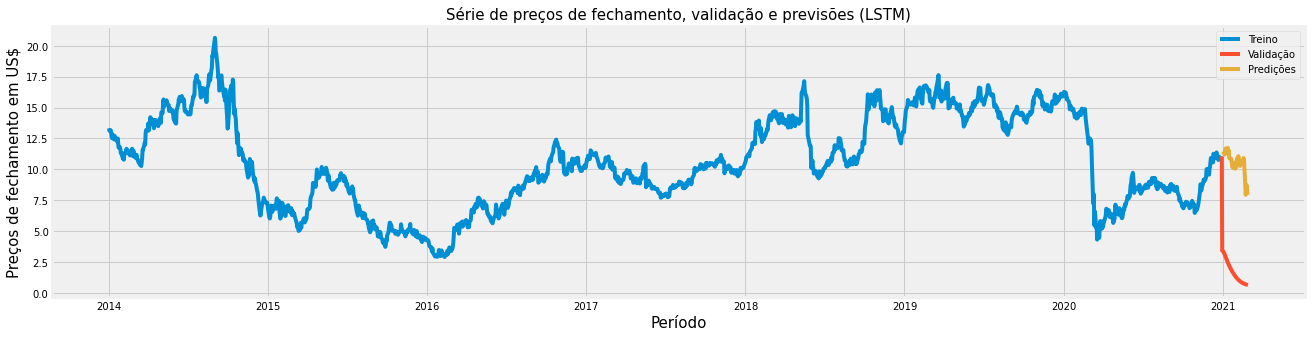

In [177]:
plt.figure(figsize=(20,5))
plt.title('Série de preços de fechamento, validação e previsões (LSTM)',size=15)
plt.xlabel('Período',size=15)
plt.ylabel('Preços de fechamento em US$',size=15)
plt.plot(df['Close'])
plt.plot(predicoes['Previsões'])
plt.plot(df2)
plt.legend(['Treino','Validação','Predições'])
plt.show()